## Data Loading and Initial Setup

Here we import all necessary libraries and set up our development environment:
- Data manipulation: pandas, numpy
- Visualization: matplotlib, seaborn
- Machine learning: scikit-learn, XGBoost
- Model tracking: MLflow

We'll use these libraries throughout the notebook for data processing, model training, and evaluation.

In [18]:
# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import unique

# MLflow
import mlflow
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient
import inspect

# Scikit-learn preprocessing and pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

# Metrics
from sklearn.metrics import (
    accuracy_score, roc_auc_score, confusion_matrix, 
    ConfusionMatrixDisplay, roc_curve, auc,
    precision_score, recall_score, f1_score
)

from utils import log_class_model_run

# Logging configuration
import logging
logging.getLogger("mlflow.models.model").setLevel(logging.ERROR)

# Warnings management
import warnings
import joblib

In [2]:
mlflow.set_tracking_uri("file:///C:/Users/Galyna/mlruns")
print(mlflow.get_tracking_uri())

file:///C:/Users/Galyna/mlruns


In [3]:
mlflow.set_experiment("Social Media Project Binary Classification")
mlflow.set_experiment_tag("scikit-learn", "lr")

In [4]:
df = pd.read_csv('data.csv') 

## Feature Engineering and Preprocessing

In this section, we:
1. Create a binary target variable for conflicts over social media (High/Low)
2.  Separate features into numeric and categorical columns
3. Set up preprocessing pipelines for these types of features:
   - Numeric features: StandardScaler
   - Categorical features: OneHotEncoder
   - Country: TargetEncoder

In [5]:
df["Conflicts_Over_Social_Media_Binary"] = df["Conflicts_Over_Social_Media"].apply(lambda x: 0 if x <= 2 else 1).astype(int)


Text(0, 0.5, 'Count')

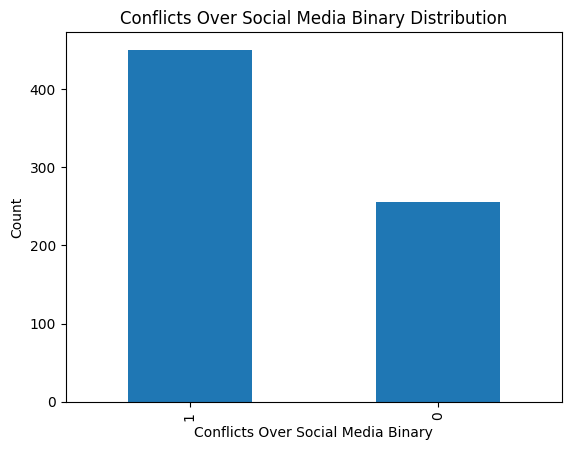

In [6]:
df["Conflicts_Over_Social_Media_Binary"].value_counts().plot(kind='bar', title='Conflicts Over Social Media Binary Distribution')
plt.xlabel('Conflicts Over Social Media Binary')
plt.ylabel('Count')

In [7]:
df.head()

Student_ID  Age  Gender Academic_Level     Country  Avg_Daily_Usage_Hours  \
0           1   19  Female  Undergraduate  Bangladesh                    5.2   
1           2   22    Male       Graduate       India                    2.1   
2           3   20  Female  Undergraduate         USA                    6.0   
3           4   18    Male    High School          UK                    3.0   
4           5   21    Male       Graduate      Canada                    4.5   

  Most_Used_Platform Affects_Academic_Performance  Sleep_Hours_Per_Night  \
0          Instagram                          Yes                    6.5   
1            Twitter                           No                    7.5   
2             TikTok                          Yes                    5.0   
3            YouTube                           No                    7.0   
4           Facebook                          Yes                    6.0   

   Mental_Health_Score Relationship_Status  Conflicts_Over_Social_Media  \
0                    6     In Relationship                            3   
1                    8              Single                            0   
2                    5         Complicated                            4   
3                    7              Single                            1   
4                    6     In Relationship                            2   

   Addicted_Score  Conflicts_Over_Social_Media_Binary  
0               8                                   1  
1               3                                   0  
2               9                                   1  
3               4                                   0  
4               7                                   0

In [8]:
exclude_cols = ['Student_ID', 'Conflicts_Over_Social_Media', 'Country', 'Conflicts_Over_Social_Media_Binary', 'Addicted_Score'] 
numeric_cols = df.select_dtypes(include='number').columns
numeric_cols = [col for col in numeric_cols if col not in exclude_cols]
print(numeric_cols)

categoric_cols = df.select_dtypes(include='object').columns
categoric_cols = [col for col in categoric_cols if col not in exclude_cols]
print(categoric_cols)

['Age', 'Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night', 'Mental_Health_Score']
['Gender', 'Academic_Level', 'Most_Used_Platform', 'Affects_Academic_Performance', 'Relationship_Status']


## Model Development

### Data Split and Pipeline Setup
We split our data into training and validation sets with a 80-20 split ratio. For the models, we:
1. Create preprocessing pipelines that combine numeric and categorical transformers
2. Set up model hyperparameters
3. Create full pipelines that combine preprocessing and model training
4. Train the models and make predictions

We'll implement two models:
1. Logistic Regression - as a baseline model
2. XGBoost - as our main model

In [9]:
numeric_pipe  = Pipeline([('std_scaler', StandardScaler())])
categorical_ohe_pipe = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))])
country_te_pipe = Pipeline([('target_enc', TargetEncoder())])

In [10]:
lr_params = {
    "solver": "liblinear",
    "class_weight":'balanced',
    "C": 0.1, 
    "max_iter": 1000,
    "random_state": 42,
}

In [11]:
# Define preprocessing and pipeline
preprocessor = ColumnTransformer([
    ('numeric',          numeric_pipe,      numeric_cols),
    ('categorical_ohe',  categorical_ohe_pipe, categoric_cols),
    ('country_te',       country_te_pipe,   ['Country'])
])

lr_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(**lr_params)) 
])

In [12]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Conflicts_Over_Social_Media_Binary'])

In [13]:
input_cols = numeric_cols + categoric_cols + ['Country']
target_col = 'Conflicts_Over_Social_Media_Binary'
train_inputs, train_targets = train_df[input_cols].copy(), train_df[target_col].copy()
val_inputs, val_targets = val_df[input_cols].copy(), val_df[target_col].copy()

In [14]:
# Fit the model and get predictions to check class balance
lr_model.fit(train_inputs, train_targets)
train_preds = lr_model.predict(train_inputs)
val_preds = lr_model.predict(val_inputs)

##  Model Evaluation and MLflow Tracking

#### Logistic Regression

In [15]:
if mlflow.active_run():
    mlflow.end_run()   

In [16]:
log_class_model_run(
    model=lr_model,
    params=lr_params,
    train_X=train_inputs, train_y=train_targets,
    val_X=val_inputs,     val_y=val_targets,
    model_name="Logistic Regression Model")

Registered model 'Logistic Regression Model' already exists. Creating a new version of this model...
Created version '5' of model 'Logistic Regression Model'.


{'accuracy_train': 0.9929078014184397,
 'precision_train': 0.9917127071823204,
 'recall_train': 0.9972222222222222,
 'f1_train': 0.9944598337950139,
 'accuracy_val': 1.0,
 'precision_val': 1.0,
 'recall_val': 1.0,
 'f1_val': 1.0,
 'roc_auc_train': 0.9972358387799565,
 'roc_auc_val': 1.0}

#### XGBoost

In [17]:
cat_features = train_inputs.select_dtypes(include='object').columns
train_inputs[cat_features] = train_inputs[cat_features].astype('category')
val_inputs[cat_features] = val_inputs[cat_features].astype('category')

In [20]:
xgb_params = {
    "max_depth": 3,
    "n_estimators": 10,
    "enable_categorical": True,
    "random_state": 42
}


xgb = XGBClassifier(
        ** xgb_params,
     ).fit(train_inputs, train_targets)


log_class_model_run(
    model=xgb,
    params=xgb_params,
    train_X=train_inputs, train_y=train_targets,
    val_X=val_inputs,     val_y=val_targets,
    model_name="XGBoost"
)

Registered model 'XGBoost' already exists. Creating a new version of this model...
Created version '18' of model 'XGBoost'.


{'accuracy_train': 0.9946808510638298,
 'precision_train': 0.9917355371900827,
 'recall_train': 1.0,
 'f1_train': 0.995850622406639,
 'accuracy_val': 1.0,
 'precision_val': 1.0,
 'recall_val': 1.0,
 'f1_val': 1.0,
 'roc_auc_train': 0.998134531590414,
 'roc_auc_val': 1.0}

In [25]:
social_media = {
    'model': xgb,  # Trained XGBoost model
    'numeric_cols': numeric_cols,
    'categoric_cols': categoric_cols,
    'input_cols': train_inputs.columns.tolist(),  # All input columns, in order
    'target_col': target_col,
    'label_map': {0: 'Low', 1: 'High'},  # Map model output to human labels
    'model_type': 'XGBoost',
    'version': '2025-07-13',
    'metrics': {
        'accuracy': accuracy_score(val_targets, xgb.predict(val_inputs)),
        'f1': f1_score(val_targets, xgb.predict(val_inputs)),
        'roc_auc': roc_auc_score(val_targets, xgb.predict_proba(val_inputs)[:,1])
    },
    'class_names': ['Low', 'High'],
    'input_example': train_inputs.iloc[0].to_dict(),  # Example input row
    'description': 'XGBoost classifier for predicting social media conflict (High/Low) based on survey features.'
}

# In your Streamlit app, always convert categoric columns to 'category' dtype before prediction:
# for col in social_media['categoric_cols']:
#     user_input[col] = user_input[col].astype('category')

### Multiclass Classification. 
#### One versus Rest Classifier. 

In [22]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Conflicts_Over_Social_Media'])

In [23]:
mlflow.set_experiment("Social Media Project Multiclass Classification")

<Experiment: artifact_location='file:///C:/Users/Galyna/mlruns/830411302848788280', creation_time=1751132393946, experiment_id='830411302848788280', last_update_time=1751132393946, lifecycle_stage='active', name='Social Media Project Multiclass Classification', tags={'scikit-learn': 'log_reg_multinomial'}>

In [26]:
svc_params = {
    "C": 1.0,
    "class_weight": "balanced",
    "max_iter": 1000,
    "random_state": 42
}


# Initialize LinearSVC directly
svc_clf = LinearSVC()

# Build full pipeline
svc_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', svc_clf)
])

# Fit the pipeline
svc_pipeline.fit(train_inputs, train_targets)

# Define logging params
log_params = {
    **svc_params,
    "model_type": "LinearSVC",
    "multiclass_strategy": "ovr"
}

# Log the model run
log_class_model_run(
    model=svc_pipeline,
    train_X=train_inputs,
    train_y=train_targets,
    val_X=val_inputs,
    val_y=val_targets,
    model_name="Multiclass LinearSVC One-vs-Rest",
    params=log_params
)

Registered model 'Multiclass LinearSVC One-vs-Rest' already exists. Creating a new version of this model...
Created version '9' of model 'Multiclass LinearSVC One-vs-Rest'.


{'accuracy_train': 0.9946808510638298,
 'precision_train': 0.9917355371900827,
 'recall_train': 1.0,
 'f1_train': 0.995850622406639,
 'accuracy_val': 1.0,
 'precision_val': 1.0,
 'recall_val': 1.0,
 'f1_val': 1.0,
 'roc_auc_train': 0.9997957516339869,
 'roc_auc_val': 1.0}

#### Softmax Classifier. 

In [27]:
# Define hyperparameters
lr_multinom_params = {
    "C": 1.0,
    "class_weight": "balanced",
    "max_iter": 1000,
    "random_state": 42,
    "multi_class": "multinomial"  # or "ovr"
}

# Initialize LogisticRegression
lr_clf = LogisticRegression(**lr_multinom_params)

# 5Build full pipeline
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lr_clf)
])

# Fit the pipeline
lr_pipeline.fit(train_inputs, train_targets)

# 7Define logging params
log_params = {
    **lr_multinom_params,
    "model_type": "LogisticRegression"
}

# Log the model run
log_class_model_run(
    model=lr_pipeline,
    train_X=train_inputs,
    train_y=train_targets,
    val_X=val_inputs,
    val_y=val_targets,
    model_name="Multinomial Logistic Regression (Softmax)",
    params=log_params
)

c:\Users\Galyna\anaconda3\envs\ml2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1254: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


Registered model 'Multinomial Logistic Regression (Softmax)' already exists. Creating a new version of this model...
Created version '2' of model 'Multinomial Logistic Regression (Softmax)'.


{'accuracy_train': 0.9946808510638298,
 'precision_train': 0.9917355371900827,
 'recall_train': 1.0,
 'f1_train': 0.995850622406639,
 'accuracy_val': 1.0,
 'precision_val': 1.0,
 'recall_val': 1.0,
 'f1_val': 1.0,
 'roc_auc_train': 0.9997276688453159,
 'roc_auc_val': 1.0}

###  One versus One Classifier. 

In [28]:
# Define hyperparameters for SVC
ovo_params = {
    "kernel": "linear",  # Makes it equivalent to LinearSVC
    "C": 1.0,
    "class_weight": "balanced",
    "random_state": 42,
    "decision_function_shape": "ovo"  # One-vs-One
}

# Initialize SVC with one-vs-one
svc_ovo_clf = SVC(**ovo_params)

# Build full pipeline
svc_ovo_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', svc_ovo_clf)
])

# Fit the pipeline
svc_ovo_pipeline.fit(train_inputs, train_targets)

# Define logging params
log_params = {
    **ovo_params,
    "model_type": "SVC",
    "multiclass_strategy": "ovo"
}

# Log the model run
log_class_model_run(
    model=svc_ovo_pipeline,
    train_X=train_inputs,
    train_y=train_targets,
    val_X=val_inputs,
    val_y=val_targets,
    model_name="Multiclass SVC One-vs-One",
    params=log_params
)

Registered model 'Multiclass SVC One-vs-One' already exists. Creating a new version of this model...
Created version '6' of model 'Multiclass SVC One-vs-One'.


{'accuracy_train': 0.9946808510638298,
 'precision_train': 0.9917355371900827,
 'recall_train': 1.0,
 'f1_train': 0.995850622406639,
 'accuracy_val': 1.0,
 'precision_val': 1.0,
 'recall_val': 1.0,
 'f1_val': 1.0,
 'roc_auc_train': 0.9983251633986928,
 'roc_auc_val': 1.0}